In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats import diagnostic as sms
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from itertools import zip_longest as lzip
import missingno as msno
from scipy.stats import ttest_ind

In [2]:
#file1 = '/Users/Павел/Documents/Курсовой проект/XLS/Countries.csv'
file1 = '/Users/Administrator/Documents/GitHub/Data-Analyst-Project/XLS/Countries.csv'
df = pd.read_csv(file1)
df

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,GDP_USD,Inflation,kg_per_person,kg_per_GDP
0,Albania,1996,273411.0,No,NaN,NaN,NaN,1557925.0,985.82,12.725478,0.18,277.34
1,Albania,1997,222897.0,No,NaN,NaN,NaN,1550237.0,688.82,33.180274,0.14,323.59
2,Albania,1998,243309.0,No,NaN,NaN,NaN,1540864.0,795.88,20.642859,0.16,305.71
3,Albania,1999,420293.0,No,NaN,NaN,NaN,1530526.0,1010.37,0.389438,0.27,415.98
4,Albania,2000,303615.0,No,NaN,NaN,NaN,1519751.0,1101.52,0.050018,0.20,275.63
...,...,...,...,...,...,...,...,...,...,...,...,...
3154,Zimbabwe,2012,629857.0,No,NaN,NaN,NaN,4559903.0,1238.60,3.725327,0.14,508.52
3155,Zimbabwe,2013,556758.0,No,NaN,NaN,NaN,4624557.0,1362.30,1.634950,0.12,408.69
3156,Zimbabwe,2014,576602.0,No,NaN,NaN,NaN,4688428.0,1372.21,-0.197785,0.12,420.20
3157,Zimbabwe,2015,486762.0,No,NaN,NaN,NaN,4751674.0,1386.42,-2.430968,0.10,351.09


# Проверка миссингов
msno.bar(df);

In [3]:
df.columns

Index(['Country', 'Year', 'Total_weight_kg', 'availability_of_metro', 'lines',
       'stations', 'annual_ridership_mill', 'Population_eating_chocolate',
       'GDP_USD', 'Inflation', 'kg_per_person', 'kg_per_GDP'],
      dtype='object')

In [4]:
# Вычисляем средние значения по странам
country_means = df.groupby('Country')['Total_weight_kg'].transform('mean')
# Заменяем пропуски и нулевые значения на средние по стране
df['Total_weight_kg'] = df['Total_weight_kg'].mask(
    (df['Total_weight_kg'].isna()) | (df['Total_weight_kg'] == 0),
    country_means)

In [5]:
# Убедимся, что 'Inflation' — числовой столбец (если есть строки, преобразуем в числа)
df['Inflation'] = pd.to_numeric(df['Inflation'], errors='coerce')
# Вычисляем среднее значение Inflation по каждому году
inflation_means_by_year = df.groupby('Year')['Inflation'].transform('mean')
# Заменяем пропуски в 'Inflation' на средние значения по году
df['Inflation'] = df['Inflation'].fillna(inflation_means_by_year)

In [6]:
# Создаем словарь с правилами для заполнения пропусков
replacement_rules = {
    'Faroe Islands': ('Denmark', 0.015),
    'Mayotte': ('Comoros', 2),
    'Netherlands Antilles': ('Netherlands', 0.005),
    'Sudan': ('Egypt', 0.3),
    'Wallis and Futuna Islands': ('New Zealand', 0.001)
}
# Обрабатываем каждое правило
for country, (source_country, multiplier) in replacement_rules.items():
    # Находим строки с пропусками GDP_USD для текущей страны
    missing_mask = (df['Country'] == country) & (df['GDP_USD'].isna())
    
    # Для каждой строки с пропуском находим соответствующее значение из страны-источника по году
    for idx in df[missing_mask].index:
        year = df.at[idx, 'Year']
        # Ищем GDP_USD для страны-источника в том же году
        source_gdp = df.loc[(df['Country'] == source_country) & (df['Year'] == year), 'GDP_USD'].values
        
        if len(source_gdp) > 0:  # Если значение найдено
            df.at[idx, 'GDP_USD'] = source_gdp[0] * multiplier

# Проверяем результат
result = df[df['Country'].isin(replacement_rules.keys())][['Country', 'Year', 'GDP_USD']]
result.head(3)

,Country,Year,GDP_USD
1016,Faroe Islands,1996,534.33300
1017,Faroe Islands,1997,491.69715
1018,Faroe Islands,1998,500.19135


In [7]:
# 1. Заполнение пропусков в kg_per_person: total_weight_kg / Population_eating_chocolate
mask_kg_per_person = df['kg_per_person'].isna()
df.loc[mask_kg_per_person, 'kg_per_person'] = (
    df.loc[mask_kg_per_person, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_person, 'Population_eating_chocolate'])
# 2. Заполнение пропусков в kg_per_GDP: total_weight_kg / GDP_USD
mask_kg_per_gdp = df['kg_per_GDP'].isna()
df.loc[mask_kg_per_gdp, 'kg_per_GDP'] = (
    df.loc[mask_kg_per_gdp, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_gdp, 'GDP_USD'])

In [8]:
df.isna().sum()

Country                           0
Year                              0
Total_weight_kg                   0
availability_of_metro             0
lines                          2139
stations                       2139
annual_ridership_mill          2139
Population_eating_chocolate       0
GDP_USD                           0
Inflation                         0
kg_per_person                     0
kg_per_GDP                        0
dtype: int64

In [9]:
# Сохранение результата
output_file = "results_data.xlsx"
df.to_excel(output_file, index=False, engine='openpyxl')

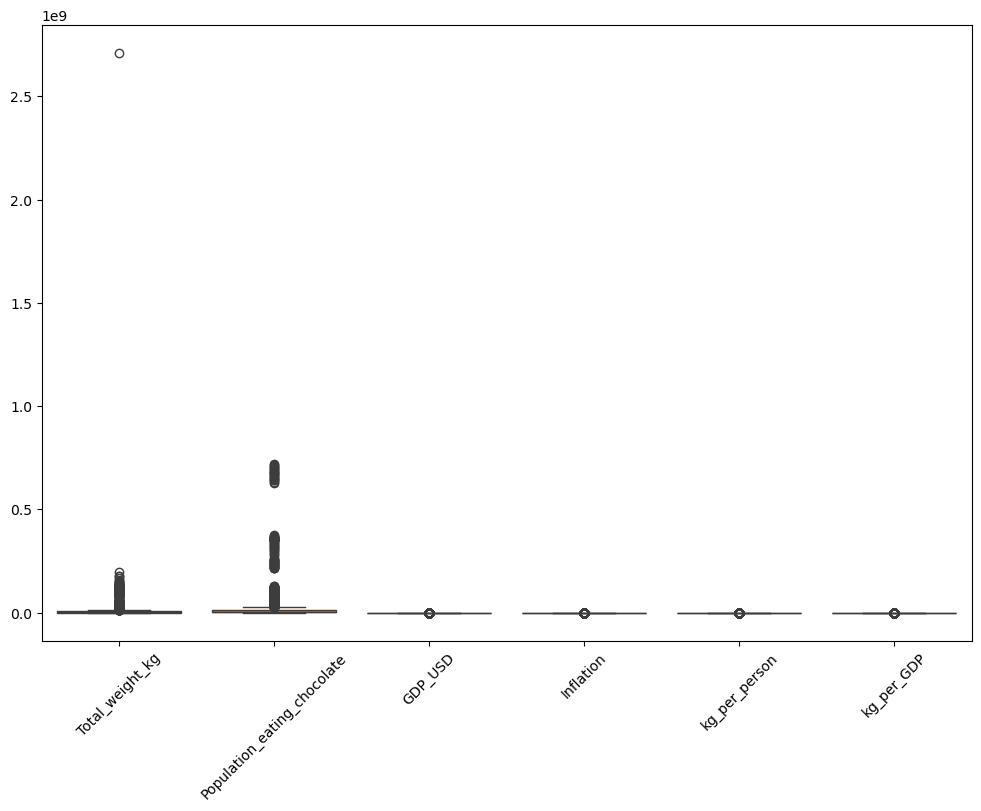

In [10]:
# 1 ЭТАП
# Проверка и удаление выбросов
numeric_cols = ['Total_weight_kg', 'Population_eating_chocolate', 'GDP_USD', 'Inflation', 'kg_per_person', 'kg_per_GDP']
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.show()

Обнаружен значительный выброс в столбце 'Total_weight_kg'

In [11]:
def find_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > threshold].index.tolist()
outliers_indices = find_outliers_zscore(df, 'Total_weight_kg', threshold=4) # Чем выше threshold, тем строже фильтрация
print(f"Найдено выбросов в 'Total_weight_kg': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
# Полное удаление строки с выбросом
dfC = df.drop(index=outliers_indices).copy()

Найдено выбросов в 'Total_weight_kg': 1
Индексы строк с выбросами: [782]


In [12]:
dfC[780:783]

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,GDP_USD,Inflation,kg_per_person,kg_per_GDP
780,Croatia,2011,6330609.0,No,NaN,NaN,NaN,3339043.0,14883.62,2.272727,1.90,425.34
781,Croatia,2012,6706156.0,No,NaN,NaN,NaN,3322204.0,13544.71,3.412073,2.02,495.11
783,Croatia,2014,14319371.0,No,NaN,NaN,NaN,3291194.0,13939.26,-0.215196,4.35,1027.27


In [13]:
# 2 ЭТАП
# Сравнение средних 'Total_weight_kg' между группами с метро
with_metro = dfC[dfC['availability_of_metro'] == "Yes"]['Total_weight_kg']
without_metro = dfC[dfC['availability_of_metro'] == "No"]['Total_weight_kg']
t_statistic, p_value = stats.ttest_ind(with_metro, without_metro)
f"results_ttest: T-статистика: {t_statistic:.4f}, P-значение: {p_value:.4f}"

'results_ttest: T-статистика: 25.8903, P-значение: 0.0000'

Высокая T-статистика (25.89)
Это означает, что разница в средних значениях между группами очень большая (чем выше |T|, тем значимее разница).
P-значение ≈ 0.0000 (p < 0.05) Поскольку p-value < 0.05 (и даже < 0.001), мы отвергаем нулевую гипотезу (H₀: "нет разницы между группами").
Вывод: Разница в потреблении шоколада между городами с метро и без метро статистически значима.

In [14]:
print("Среднее потребление с метро:", with_metro.mean())
print("Среднее потребление без метро:", without_metro.mean())

Среднее потребление с метро: 19708190.090689655
Среднее потребление без метро: 2251647.910584704


In [15]:
# 3 ЭТАП
# Анализ корреляции
df1=df[['Year', 'Total_weight_kg', 'lines','stations','annual_ridership_mill','Population_eating_chocolate', 'GDP_USD','Inflation','kg_per_person','kg_per_GDP']]
df1.corr().round(3)

,Year,Total_weight_kg,lines,stations,annual_ridership_mill,Population_eating_chocolate,GDP_USD,Inflation,kg_per_person,kg_per_GDP
Year,1.000,0.051,-0.006,-0.005,-0.026,0.011,0.205,-0.117,0.039,0.013
Total_weight_kg,0.051,1.000,0.127,0.085,-0.027,0.070,0.142,-0.021,0.933,0.938
lines,-0.006,0.127,1.000,0.992,-0.035,0.929,-0.016,-0.029,-0.138,0.162
stations,-0.005,0.085,0.992,1.000,-0.034,0.920,-0.039,-0.030,-0.131,0.148
annual_ridership_mill,-0.026,-0.027,-0.035,-0.034,1.000,-0.011,0.005,0.006,0.018,0.088
Population_eating_chocolate,0.011,0.070,0.929,0.920,-0.011,1.000,0.022,-0.013,-0.020,0.069
GDP_USD,0.205,0.142,-0.016,-0.039,0.005,0.022,1.000,-0.092,0.054,-0.011
Inflation,-0.117,-0.021,-0.029,-0.030,0.006,-0.013,-0.092,1.000,-0.011,0.004
kg_per_person,0.039,0.933,-0.138,-0.131,0.018,-0.020,0.054,-0.011,1.000,0.945
kg_per_GDP,0.013,0.938,0.162,0.148,0.088,0.069,-0.011,0.004,0.945,1.000


Ключевые выводы
1. Потребление шоколада (Total_weight_kg, kg_per_person, kg_per_GDP)
Total_weight_kg сильно коррелирует с:
kg_per_person (0.933) → Чем больше шоколада в стране, тем больше его потребление на человека.
kg_per_GDP (0.938) → Чем больше шоколада в стране, тем больше его потребление относительно ВВП.
Слабая связь с GDP_USD (0.142) → Богатые страны едят чуть больше шоколада, но зависимость незначительна.
kg_per_person и kg_per_GDP (0.945) — почти линейная зависимость:
Потребление на человека и на единицу ВВП очень тесно связаны.
2. Метро (lines, stations, annual_ridership_mill)
lines и stations (0.992) — почти идентичная корреляция:
Чем больше линий метро, тем больше станций (ожидаемо).
Но пассажиропоток (annual_ridership_mill) почти не зависит от числа линий/станций (-0.035)!
Возможно, в некоторых странах метро мало используется.
3. Население и экономика
Population_eating_chocolate сильно зависит от числа линий метро (0.929) и станций (0.920)!
Неожиданно! Возможно, метро строят в странах с высоким потреблением шоколада (или наоборот).
Либо это артефакт данных (например, метро есть только в развитых странах, где едят много шоколада).
GDP_USD слабо связан с шоколадом (0.142) → Богатство страны мало влияет на потребление.
Inflation почти не влияет (-0.021) → Инфляция не снижает потребление шоколада.
4. Влияние года (Year)
Почти нет связи с другими переменными (все коэффициенты близки к 0).
Потребление шоколада не растёт и не падает со временем (глобальный тренд отсутствует).

Главные инсайты
✅ 1. Потребление шоколада (Total_weight_kg) больше зависит от внутренних факторов (kg_per_person, kg_per_GDP), чем от экономики (GDP_USD) или инфляции (Inflation).
✅ 2. Метро (lines, stations) сильно связано с числом людей, едящих шоколад (Population_eating_chocolate), но не с пассажиропотоком.
❓ 3. Есть ли причинно-следственная связь?
Либо метро стимулирует потребление шоколада (например, люди покупают его в метро),
Либо метро строят в странах, где шоколад популярен.
Нужен дополнительный анализ (A/B-тест, регрессия).

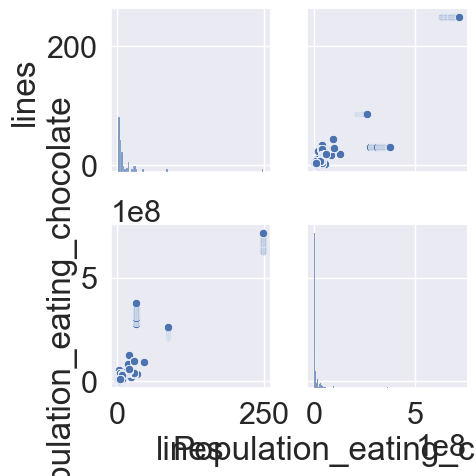

In [16]:
sns.set(style='ticks')
sns.set(font_scale=2)
sns.pairplot(df[['lines','Population_eating_chocolate']]);

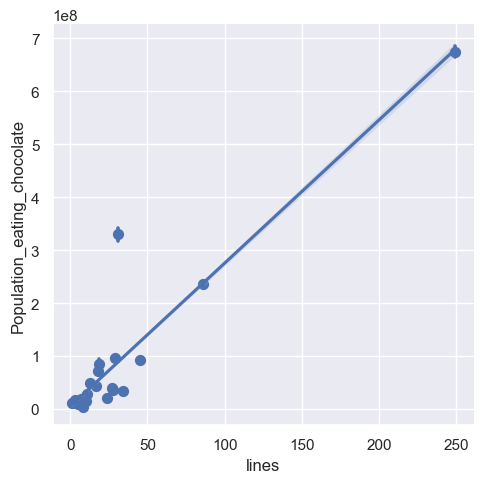

In [17]:
# Графическое изображение корреляции
sns.set(font_scale=1)
sns.lmplot(x="lines", y="Population_eating_chocolate", data=df, x_estimator=np.mean);

In [18]:
# 4 ЭТАП
# РЕГРЕСИОННЫЙ АНАЛИЗ
# Принимаем outcome - kg_per_person; predictors - availability_of_metro, Population_eating_chocolate, GDP_USD, Inflation, annual_ridership_mill, lines

In [19]:
# 1. Подготовка данных - преобразуем категориальные переменные в числовые
df1 = dfC[['kg_per_person', 'availability_of_metro', 'Population_eating_chocolate', 'GDP_USD', 'Inflation', 'annual_ridership_mill', 'lines']].copy()
# Преобразуем availability_of_metro в числовой формат (1 - есть метро, 0 - нет)
df1['availability_of_metro'] = df1['availability_of_metro'].map({'Yes': 1, 'No': 0})
# 2. Корреляционный анализ
df1.corr().round(3)

,kg_per_person,availability_of_metro,Population_eating_chocolate,GDP_USD,Inflation,annual_ridership_mill,lines
kg_per_person,1.000,-0.019,-0.111,0.391,-0.056,0.018,-0.138
availability_of_metro,-0.019,1.000,0.297,0.255,-0.017,0.093,0.122
Population_eating_chocolate,-0.111,0.297,1.000,0.022,-0.013,-0.011,0.929
GDP_USD,0.391,0.255,0.022,1.000,-0.092,0.005,-0.016
Inflation,-0.056,-0.017,-0.013,-0.092,1.000,0.006,-0.029
annual_ridership_mill,0.018,0.093,-0.011,0.005,0.006,1.000,-0.035
lines,-0.138,0.122,0.929,-0.016,-0.029,-0.035,1.000


In [ ]:
Целевая переменная (kg_per_person):
Наибольшая корреляция с GDP_USD (0.391) - положительная связь
Слабая отрицательная связь с Population_eating_chocolate (-0.111) и lines (-0.138)
Практически нулевая связь с наличием метро (-0.019)
Проблемы мультиколлинеарности:
Очень высокая корреляция между:
Population_eating_chocolate и lines (0.929)
availability_of_metro и Population_eating_chocolate (0.297)
Это может исказить оценки модели

In [20]:
# 3.1 Упрощенная модель без мультиколлинеарных предикторов (без Population_eating_chocolate и lines)
model_v1 = smf.ols('kg_per_person ~ availability_of_metro + GDP_USD + Inflation', data=df1).fit()
model_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          kg_per_person   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     212.5
Date:                Fri, 11 Jul 2025   Prob (F-statistic):          1.55e-125
Time:                        11:44:53   Log-Likelihood:                -6382.6
No. Observations:                3158   AIC:                         1.277e+04
Df Residuals:                    3154   BIC:                         1.280e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6773      0.045     15.209      0.000       0.590       0.765
availability_of_metro    -0.5554      0.074     -7.524      0.000      -0.700      -0.411
GDP_USD                4.748e-05    1.9e-06     24.985      0.000    4.38e-05    5.12e-05
Inflation                -0.0018      0.002     -1.183      0.237      -0.005       0.001
==============================================================================
Omnibus:                     4284.991   Durbin-Watson:                   0.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1384700.280
Skew:                           7.556   Prob(JB):                         0.00
Kurtosis:                     104.464   Cond. No.                     5.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# 3.2 Модель с логарифмированным GDP (учитывая его важность)
df1['log_GDP'] = np.log(df1['GDP_USD'])
model_v2 = smf.ols('kg_per_person ~ availability_of_metro + log_GDP + Inflation', data=df1).fit()
model_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          kg_per_person   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     263.5
Date:                Fri, 11 Jul 2025   Prob (F-statistic):          1.41e-152
Time:                        11:44:58   Log-Likelihood:                -6320.2
No. Observations:                3158   AIC:                         1.265e+04
Df Residuals:                    3154   BIC:                         1.267e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.7855      0.182    -20.795      0.000      -4.142      -3.429
availability_of_metro    -0.7692      0.074    -10.372      0.000      -0.915      -0.624
log_GDP                   0.6058      0.022     27.868      0.000       0.563       0.648
Inflation                -0.0007      0.002     -0.435      0.664      -0.004       0.002
==============================================================================
Omnibus:                     4249.529   Durbin-Watson:                   0.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1358475.193
Skew:                           7.435   Prob(JB):                         0.00
Kurtosis:                     103.513   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# 3.3 Модель без метро для сравнения
model_nometro = smf.ols('kg_per_person ~ GDP_USD + Inflation', data=df1).fit()
# Сравнение моделей
from statsmodels.stats.anova import anova_lm
anova_lm(model_nometro, model_v1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3155.0,10719.172302,0.0,NaN,NaN,NaN
1,3154.0,10530.180251,1.0,188.992052,56.606907,6.901588e-14


In [27]:
# 4. Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(df1['kg_per_person'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')


Проверка нормальности распределения зависимой переменной:
Shapiro-Wilk Test Statistic: 0.5286
p-value: 0.0000000000



Анализ распределения:


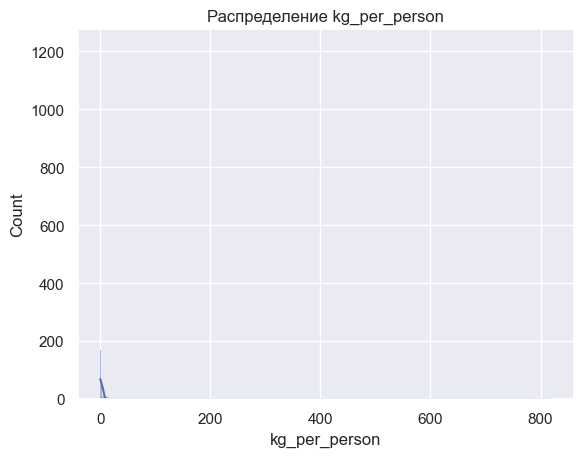

Коэффициент асимметрии: 54.66279887839721


In [25]:
# 5. Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=df, x="kg_per_person", kde=True)
plt.title('Распределение kg_per_person')
plt.show()
skewness = df['kg_per_person'].skew()
print(f'Коэффициент асимметрии: {skewness}')

In [26]:
# 6. Модель с логарифмированием (если распределение не нормальное)
print("\nМодель с логарифмированием зависимой переменной:")
df['log_kg'] = np.log(df['kg_per_person'])
model_log = smf.ols(formula='log_kg ~ availability_of_metro + GDP_USD + Population_eating_chocolate + Inflation', 
                    data=df).fit()
model_log.summary()


Модель с логарифмированием зависимой переменной:


C:\Users\Administrator\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Administrator\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1734: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_kg   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Jul 2025   Prob (F-statistic):                nan
Time:                        11:00:23   Log-Likelihood:                    nan
No. Observations:                3159   AIC:                               nan
Df Residuals:                    3154   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                           nan        nan        nan        nan         nan         nan
availability_of_metro[T.Yes]        nan        nan        nan        nan         nan         nan
GDP_USD                             nan        nan        nan        nan         nan         nan
Population_eating_chocolate         nan        nan        nan        nan         nan         nan
Inflation                           nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                     1.75e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 7. Проверка мультиколлинеарности (VIF)
print("\nПроверка мультиколлинеарности:")
X = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [VIF(X, i) for i in range(X.shape[1])]
print(vif_data)

# 8. Проверка автокорреляции (Дарбин-Уотсон)
print("\nТест Дарбина-Уотсона:")
name = ["Durbin-Watson statistic"]
test = [sms.durbin_watson(model.resid)]
print(lzip(name, test))

# 9. Проверка гетероскедастичности (Бреуш-Паган)
print("\nТест Бреуша-Пагана на гетероскедастичность:")
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model.resid, model.model.exog)
print(lzip(name, test))

# 10. Анализ выбросов (леверидж)
print("\nАнализ выбросов:")
fig, ax = plt.subplots(figsize=(12, 12))
sm.graphics.plot_leverage_resid2(model, ax=ax)
plt.show()

# 11. Робастная регрессия (если есть выбросы)
print("\nРобастная регрессия:")
robust_model = sm.RLM(df['kg_per_person'], 
                     sm.add_constant(df[['availability_of_metro', 'GDP_USD', 
                                       'Population_eating_chocolate', 'Inflation']])).fit()
print(robust_model.summary())

# 12. Визуализация всех переменных
print("\nДиаграммы размаха для всех переменных:")
plt.figure(figsize=(12, 8))
plt.boxplot([df['kg_per_person'], df['GDP_USD'], 
            df['Population_eating_chocolate'], df['Inflation']], 
           tick_labels=['kg_per_person', 'GDP_USD', 
                       'Population_eating_chocolate', 'Inflation'])
plt.title('Диаграммы размаха для переменных')
plt.ylabel('Значения')
plt.grid(True)
plt.show()

# 13. Центрирование переменных (дополнительно)
print("\nМодель с центрированными переменными:")
df_centered = df.copy()
cols_to_center = ['GDP_USD', 'Population_eating_chocolate', 'Inflation']
df_centered[cols_to_center] = df[cols_to_center] - df[cols_to_center].mean()
centered_model = smf.ols('kg_per_person ~ availability_of_metro + GDP_USD + Population_eating_chocolate + Inflation', 
                        data=df_centered).fit()
print(centered_model.summary())

                             kg_per_person  availability_of_metro  \
kg_per_person                        1.000                 -0.014   
availability_of_metro               -0.014                  1.000   
Population_eating_chocolate         -0.020                  0.297   
GDP_USD                              0.054                  0.255   
Inflation                           -0.011                 -0.017   
annual_ridership_mill                0.018                  0.093   
lines                               -0.138                  0.122   

                             Population_eating_chocolate  GDP_USD  Inflation  \
kg_per_person                                     -0.020    0.054     -0.011   
availability_of_metro                              0.297    0.255     -0.017   
Population_eating_chocolate                        1.000    0.022     -0.013   
GDP_USD                                            0.022    1.000     -0.092   
Inflation                                      

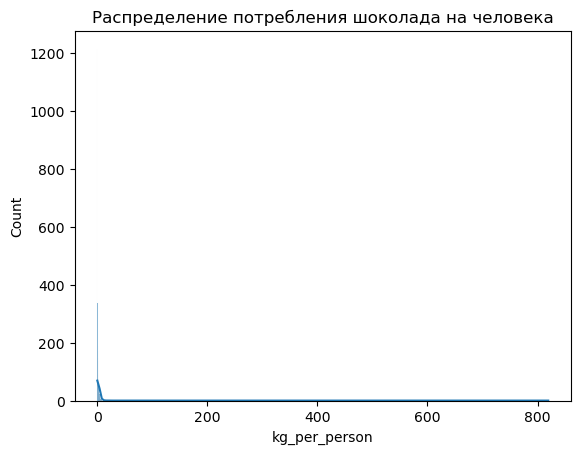


Коэффициент асимметрии для kg_per_person: 54.66279887839721


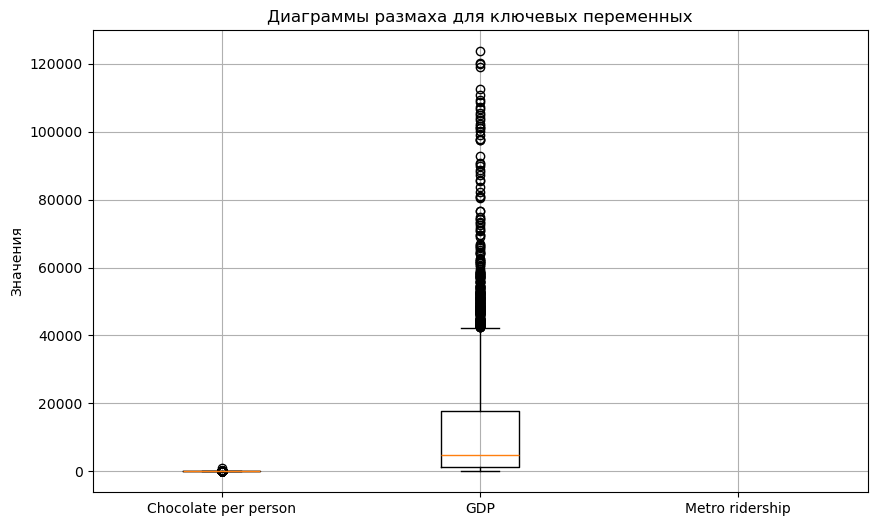

In [25]:
# Сначала преобразуем бинарную переменную availability_of_metro в числовой формат
df['availability_of_metro'] = df['availability_of_metro'].map({'Yes': 1, 'No': 0})

# Теперь выберем переменные для модели
df_model = df[['kg_per_person', 'availability_of_metro', 'Population_eating_chocolate', 
               'GDP_USD', 'Inflation', 'annual_ridership_mill', 'lines']].copy()
# Теперь корреляционный анализ должен работать
print(df_model.corr().round(3))

# Основная регрессионная модель
model = smf.ols(formula='kg_per_person ~ availability_of_metro + Population_eating_chocolate + GDP_USD + Inflation + annual_ridership_mill + lines', 
                data=df_model).fit()
print(model.summary())

# Проверка нормальности остатков
shapiro_test = stats.shapiro(model.resid)
print(f'\nShapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')

# Проверка мультиколлинеарности
X = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [VIF(X, i) for i in range(X.shape[1])]
print("\nVIF Analysis:")
print(vif_data)

# Проверка гетероскедастичности
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model.resid, model.model.exog)
print("\nBreusch-Pagan test for heteroskedasticity:")
print(list(zip(name, test)))

# Визуализация распределения зависимой переменной
sns.histplot(data=df, x="kg_per_person", kde=True)
plt.title('Распределение потребления шоколада на человека')
plt.show()

# Коэффициент асимметрии
skewness = df['kg_per_person'].skew()
print(f'\nКоэффициент асимметрии для kg_per_person: {skewness}')

# Диагностика выбросов
plt.figure(figsize=(10, 6))
plt.boxplot([df['kg_per_person'], df['GDP_USD'], df['annual_ridership_mill']], 
            tick_labels=['Chocolate per person', 'GDP', 'Metro ridership'])
plt.title('Диаграммы размаха для ключевых переменных')
plt.ylabel('Значения')
plt.grid(True)
plt.show()

df.columns

unique_count = df.Year.nunique()
unique_count

#SELECT sql FROM sqlite_master WHERE type = 'view';

In [6]:
# Проведение регрессионного анализа
df_ols = smf.ols(formula='math ~ antisoc  + income + read', data=df).fit()
df_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   math   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     40.47
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.46e-21
Time:                        11:44:48   Log-Likelihood:                -865.83
No. Observations:                 243   AIC:                             1740.
Df Residuals:                     239   BIC:                             1754.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8169      1.855      4.213      0.000       4.162      11.472
antisoc        0.5390      0.385      1.400      0.163      -0.220       1.298
income         0.1108      0.027      4.077      0.000       0.057       0.164
read           0.5490      0.056      9.788      0.000       0.438       0.659
==============================================================================
Omnibus:                       30.947   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.159
Skew:                           0.806   Prob(JB):                     4.25e-10
Kurtosis:                       4.291   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Первичные выводы:
1. При R-squared = 0.337 - модель имеет умеренную предсказательную силу.
2. При F-statistic = 40.47 и Prob (F-statistic) = 3.46e-21 - модель в целом статистически значима. Предикторы income и read	имеют значительное влияние на зависимую переменную - math
3. При Skew = 0.806 - модель имеет положительную асимметрию остатков. Это подтверждается тестом на нормальность (Шапиро-Уилка), где p-value: 1.73e-08 < 0.05
4. При P(antisoc) = 0.163 - предиктор "antisoc" не имеет значительного влияния на зависимую переменную - math.
5. При Durbin-Watson = 1.943 приблизительно равно 2 - указывает на отсутствие автокорреляции.
6. При Omnibus = 30.947 и Jarque-Bera = 43.159 - тесты на нормальность остатков указывают на то, что остатки не распределены нормально.

In [7]:
shapiro_test = stats.shapiro(df['math'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')

Shapiro-Wilk Test Statistic: 0.9393
p-value: 0.0000000173


Коэффициент асимметрии: 0.8895142551476454


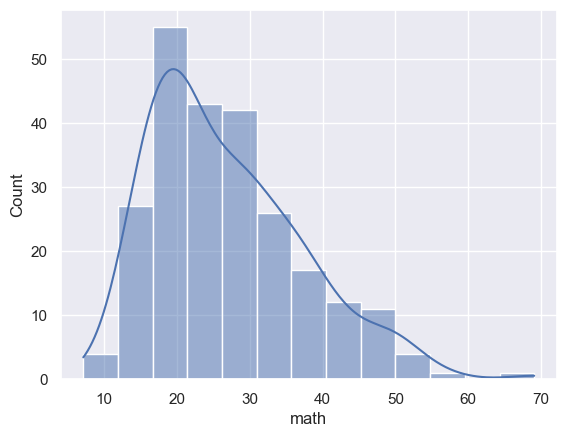

In [8]:
# Расчет коэффициента асимметрии
sns.histplot(data=df, x="math", kde=True)
skewness = df['math'].skew()
print(f'Коэффициент асимметрии: {skewness}')

In [9]:
# При проведении логарифмирования коэффициент асимметрии существенно не изменился, мультиколлинеарность увеличилась - т.е. метод не эффективен для данной модели
df_ols1 = smf.ols(formula='math ~ antisoc  + income + np.log(read)', data=df).fit()
df_ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   math   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     43.68
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           1.53e-22
Time:                        11:44:56   Log-Likelihood:                -862.63
No. Observations:                 243   AIC:                             1733.
Df Residuals:                     239   BIC:                             1747.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -36.1671      5.830     -6.204      0.000     -47.652     -24.682
antisoc          0.4537      0.380      1.193      0.234      -0.295       1.203
income           0.1034      0.027      3.846      0.000       0.050       0.156
np.log(read)    18.1859      1.777     10.234      0.000      14.685      21.687
==============================================================================
Omnibus:                       29.980   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.327
Skew:                           0.805   Prob(JB):                     1.75e-09
Kurtosis:                       4.179   Cond. No.                         374.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Durbin-Watson = 1.943 приблизительно равно 2 - указывает на отсутствие автокорреляции. 
name = ["Durbin-Watson statistic"]
test = [sms.durbin_watson(df_ols.resid)]
lzip(name, test)

[('Durbin-Watson statistic', 1.9425224842269104)]

In [11]:
# Коэффициент инфляции дисперсии для всех предикторов находится в пределах 1.0-1.03 - указывает на отсутствие значительной мультиколлинеарности.
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
X = df_ols.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = df_ols.model.exog_names
vif_data["VIF"] = [VIF(X, i) for i in range(X.shape[1])]
print(vif_data)

     feature        VIF
0  Intercept  11.293256
1    antisoc   1.018248
2     income   1.026763
3       read   1.008450


In [12]:
# По итогу центрирования удалось уменьшить влияние мультиколлинеарности (Cond. No. 68 instead 141) 
df['logmath'] = np.log(df['math'])
df_centered = df.copy()
df_centered[['read', 'logmath']] = df[['read', 'logmath']] - df_centered[['read', 'logmath']].mean()
results2 = smf.ols("math ~ antisoc  + income + read", data=df_centered).fit() # data=dat_centered
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     40.47
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.46e-21
Time:                        11:45:04   Log-Likelihood:                -865.83
No. Observations:                 243   AIC:                             1740.
Df Residuals:                     239   BIC:                             1754.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.1419      1.100     21.042      0.0

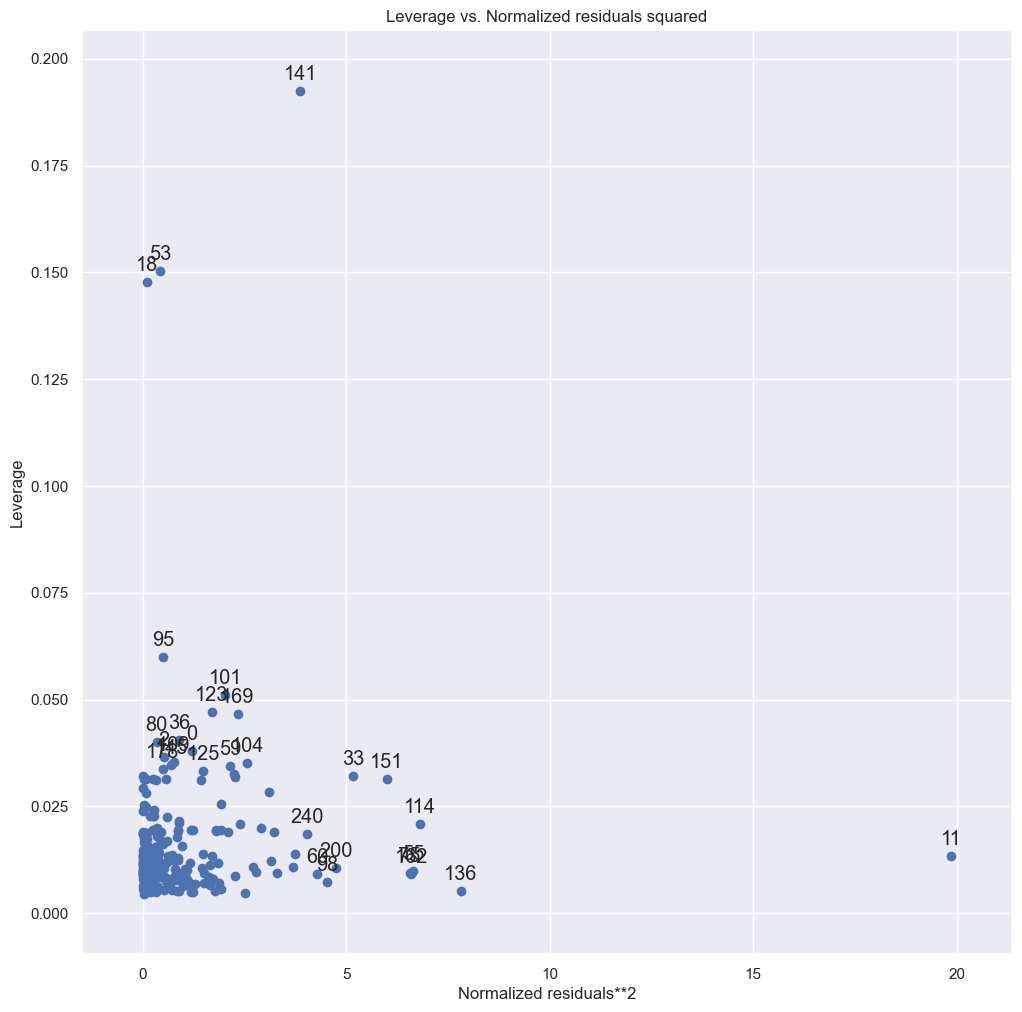

In [13]:
# На графике, показывающий влияние наблюдений на модель регрессии видно что наблюдения №11,18,53,141 являются аномальными.
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(12, 12))
fig = plot_leverage_resid2(df_ols, ax=ax)
fig;

In [14]:
# Результаты теста Бреуша-Пагана указывают на наличие гетероскедастичности в модели (при p-value = 0.022 < 0.05)
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(df_ols.resid, df_ols.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 9.541308091727952),
 ('p-value', 0.022895947978503015),
 ('f-value', 3.25592594173499),
 ('f p-value', 0.022358427685870798)]

In [15]:
# Учитывая наличие гетероскедастичности применим робастную линейную модель
# В результате значение std err для read уменьшилось (0.049 instead 0.056)
df['logmath'] = np.log(df['math'])
res = sm.RLM(df['math'], df[['read','logmath']]).fit()
print(res.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                   math   No. Observations:                  243
Model:                            RLM   Df Residuals:                      241
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 24 Mar 2025                                         
Time:                        11:45:13                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
read           0.2159      0.049      4.398      0.0

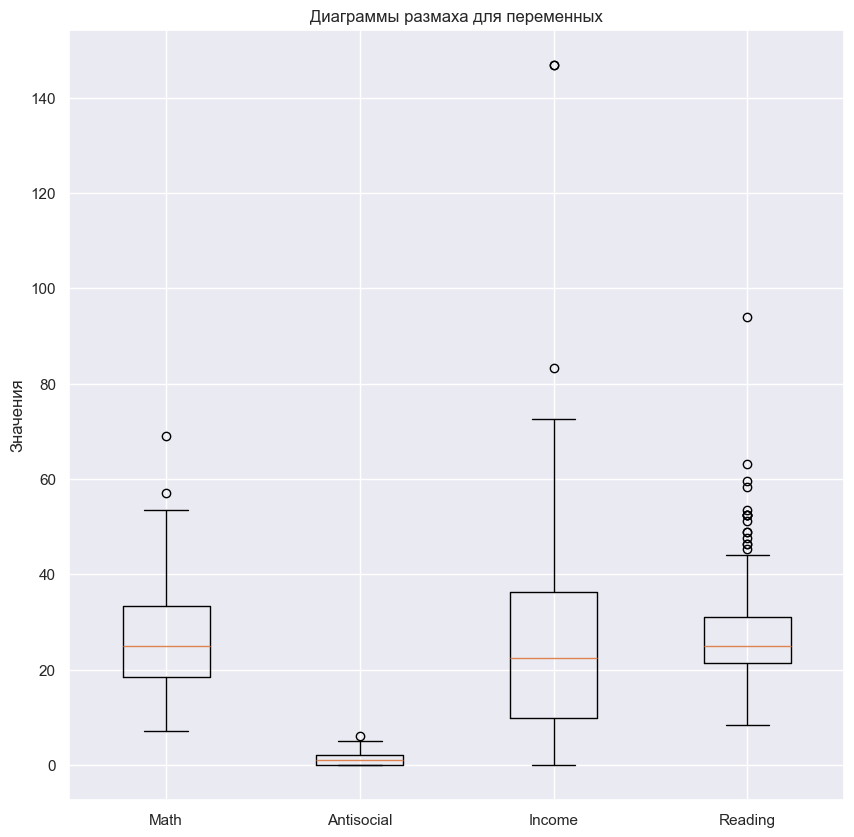

In [17]:
# При построении диаграммы размаха для переменных видно аномальное значение в income. Это указывает на значительный доход у одного из отцов и влияет на более широкий диапазон "коробок" на диаграмме.
plt.figure(figsize=(10, 10))
plt.boxplot([df['math'], df['antisoc'], df['income'], df['read']], 
            tick_labels=['Math', 'Antisocial', 'Income', 'Reading'])
plt.title('Диаграммы размаха для переменных')
plt.ylabel('Значения')
plt.grid(True)
plt.show()

# Итоговый вывод:
1. Предикторы income и read имеют значительное положительное влияние на math (p=0), в то время как влияние antisoc не является статистически значимым (p=0.163).